# Graphs
TO BE COMPLETED!!

### To do
- Graph class: adjacency matrix, degree
- Visualization: remove total angular momentum
- A* algorithm (idea from [this video](https://www.youtube.com/watch?v=A60q6dcoCjw))

### Libraries and utility function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
%matplotlib inline
import ipywidgets as widgets
import matplotlib.animation
from functools import partial


def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    ending = '\n' if current == total else '\r'

    print(f'Progress: [{arrow}{padding}] {int(fraction*100)}%', end=ending)  

### Nodes, Edges and Graph

In [31]:
class Node():
    def __init__(
        self, mass = 1.0, neigh = [], label = None
    ):
        """
        :param list[int] neigh
        """
        self.mass = mass
        self.neigh = neigh
        self.label = label
        return
    
    def degree(self):
        return len(self.neigh)
    
    def print(self):
        print(f"({self.label}) --> {self.neigh}")
        return

#----------------------------------------------------------------------------------#

class Edge():
    def __init__(
        self, start: int, end: int, directed = False, weight = 1.0, stiffness = 1, x0 = 1.0, damping = 10
    ):
        self.start = start
        self.end = end
        self.directed = directed
        self.weight = weight
        self.stiffness = stiffness
        self.x0 = x0
        self.damping = damping
        return
    
    def same(self, other):
        sameParallel = (self.start == other.start and self.end == other.end)
        sameOpposite = (self.start == other.end and self.end == other.start)
        if self.directed:
            return sameParallel
        else:
            return sameParallel or sameOpposite
    
    def print(self):
        if self.directed:
            tag = '-->'
        else:
            tag = '---'
        print(self.start,tag,self.end)
        return

#----------------------------------------------------------------------------------#

class Graph():
    def __init__(
        self, nodes: tuple[Node] = None, edges: tuple[Edge] = None,
    ):
        self.nodes = nodes
        self.edges = edges
        self.R = 2.0
        self.x = None
        if nodes is not None and self.edges is not None:
            self.init_neigh()
            self.init_x()
        return
    
    def __len__(self):
        return len(self.nodes)
    
    def connectivity(self):
        return len(self.edges)
    
    def init_neigh(self):
        for node in self.nodes:
            node.neigh = []
        for edge in self.edges:
            s,e = (edge.start, edge.end)
            self.nodes[s].neigh += [e]
            if not edge.directed:
                self.nodes[e].neigh += [s]
        return
    
    def init_x(self, R=2.0):
        N = len(self)
        self.x = np.empty((N,2), dtype=np.float32)
        self.R = R
        angles = np.linspace(0, 2*np.pi*(1-1/N), N)
        self.x[:,0] = R*np.cos(angles)
        self.x[:,1] = R*np.sin(angles)
        return
    
    def init_random(self, N, M, maxiter=10000):
        if M>N*(N-1)/2:
            print("[ERROR: too many connections]")
            return
        self.nodes = [Node(label=str(i)) for i in range(N)]
        self.edges = []
        for i in range(M):
            exists = True
            count = 0
            while exists and count<maxiter:
                count += 1
                i = np.random.randint(N)
                j = np.random.randint(i+1,i+1+(N-1))%N #different from i
                newEdge = Edge(i,j)
                exists = False
                for oldEdge in self.edges:
                    if oldEdge.same(newEdge):
                        exists = True
                        #print('exists!')
                        break
            #newEdge.print()
            self.edges += [ newEdge ]
        self.init_neigh()
        self.init_x()
        return
    
    def init_powerlaw(self, N, gamma, maxcount=10000):
        if gamma<=1:
            print("[ERROR: gamma must be > 1]")
            return
        self.nodes = [Node(label=str(i)) for i in range(N)]
        possible = False
        count = 0
        while (not possible) and (count<maxcount):
            r = np.random.rand(N)
            k = (1-(1-1/N**(gamma-1))*r)**(-1/(gamma-1)) # distributed as 1/k**gamma, 1<=k<= N
            k = np.floor(k+0.5) #round to integer
            #print("extracted k = ",k)
            possible = self.connect_nodes(k)
            count += 1
            print(f"\rAttempt {count}/{maxcount}", end='')
        print("")
        self.init_x()
        if count>=maxcount:
            print(f"[ ERROR: could not initialize scale-fre graph with gamma={gamma} ]")
            print(f"[ Last sample of degrees: {k} ]")
        return
    
    def connect_nodes(self, degrees, maxcount=10000):
        # Starting from the degree of each node, try to connect between them if possible
        if (int(np.sum(degrees))%2 == 0): # must be even
            return False
        N = len(self.nodes)
        self.edges = []
        for node in self.nodes:
            node.neigh = []
        for i in range(N-1):
            n = self.nodes[i]
            # For as many neighbours as you need:
            for j in range(int(degrees[i]) - len(n.neigh)):
                match=False
                count = 0
                # Try to find a neighbour:
                while (not match) and (count < maxcount):
                    k = ( i+1 + np.random.randint(N-1) )%N
                    # Not possible if k has already a max num of neighbours
                    if len(self.nodes[k].neigh) >= int(degrees[k]):
                        match=False
                    # Else, check if you already connected to it
                    elif sum([ nn==k for nn in n.neigh ]):
                        match=False
                    # Else OK
                    else:
                        n.neigh.append( k )
                        self.nodes[k].neigh.append( i )
                        self.edges.append( Edge(i,k) )
                        match=True
                    count += 1
                #print(f"node {i} neigh n.{j+1}: {count} attempts")
                # Could not find it in a reasonable time
                if count>=maxcount:
                    return False
        # Manually add an extra node to match the degree of the last node
        self.nodes[-1].neigh.append( N )
        self.nodes.append( Node(label=str(N)) )
        self.nodes[-1].neigh = [N-1]
        self.edges.append( Edge(N-1,N) )
        return True
    
    def relax(self, dt=0.01, tolerance=0.0001, maxcount=10000, output_every=1000):
        N = len(self)
        invN = 1/N
        m = np.array([n.mass for n in self.nodes], dtype=np.float32)
        m = m[:,None]
        x = self.x.copy()
        L = np.array([[8*self.R,8*self.R]], dtype=np.float32)
        
        dx = np.empty((N,2), dtype=np.float32)
        v = np.zeros((N,2), dtype=np.float32)
        maxdx = 10
        count = 0
        X = [x]
        while maxdx > tolerance and count<maxcount:
            f = np.zeros((N,2), dtype=np.float32) #forces
            # Bonded forces
            for edge in self.edges:
                i,j = (edge.start, edge.end)
                rij = x[i]-x[j]
                f[i] += ( -edge.stiffness*(rij-edge.x0) - edge.damping*v[i] )
            # 1/r^6 repulsion between nodes
            for i in range(N-1):
                for j in range(i+1,N):
                    xij = (x[i]-x[j])
                    rij = np.sum(xij*xij)**(6/2)
                    if rij>tolerance*10:
                        f[i] += .1 *xij/rij
                        f[j] -= .1 *xij/rij
            v += f/m*dt # simple Euler integration
            dx = v*dt
            maxdx = np.max( np.abs(dx) )
            x += dx
            xCM = np.sum(x*m, axis=0)/np.sum(m)
            x -= xCM # remove c.o.m. motion
            for dim in range(2):
                mask = x[:,dim]>0.5*L[0,dim]
                x[mask, dim] = 0.5*L[0,dim]
                v[mask, dim] *= -.99
                mask = x[:,dim]<-0.5*L[0,dim]
                x[mask, dim] = -0.5*L[0,dim]
                v[mask, dim] *= -.99
            count += 1
            if count%output_every ==0:
                X.append(x.copy())
        
        self.x = x.copy()
        #self.plot(x)
        return X, L
    
    def get_edge_lines(self, x):
        lx = []
        ly = []
        for edge in self.edges:
            s,e = (edge.start, edge.end)
            lx.append( x[s,0] )
            lx.append( x[e,0] )
            lx.append( None )
            ly.append( x[s,1] )
            ly.append( x[e,1] )
            ly.append( None )
        return lx,ly
    
    def plot(self, x, ax):
        ax.axis('equal')
        ax.plot(x[:,0],x[:,1],'ro')
        lx,ly = self.get_edge_lines(x)
        ax.plot(lx,ly, 'k', alpha=0.5)
        for i in range(len(self)):
            ax.annotate(self.nodes[i].label, (x[i,0],x[i,1]))
        #plt.show()
        return
    
    def animate(self):
        X, L = self.relax()
        L = L.T
        nevery = int(1)
        fig, ax = plt.subplots(figsize=(4,4))
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams['figure.dpi'] = 150  
        plt.ioff()
        line1, = ax.plot([], [], 'ro')
        line2, = ax.plot([], [], 'k', alpha=0.7)
        texts = [matplotlib.text.Text() for n in range(len(self))]
        def init():
            ax.set_xlim( (-0.5*L[0], 0.5*L[0]))
            ax.set_ylim( (-0.5*L[1], 0.5*L[1]))
            ax.axis('equal')
            #ax.axis('off')
            return line1,line2
        def update(frame, ln1, ln2, txts, X):
            x = X[frame]
            ln1.set_data(x[:,0], x[:,1])
            lx,ly = self.get_edge_lines(x)
            ln2.set_data(lx, ly)
            for i in range(len(self)):
                #ax.text(x[i,0]+0.01,x[i,1]+0.01, self.nodes[i].label)
                dic = {'x': x[i,0]+0.01, 'y':x[i,1]+0.01, 'text': self.nodes[i].label }
                txts[i].update(dic)
            plt.title(f"frame {frame}")
            return ln1,ln2
        
        return matplotlib.animation.FuncAnimation(fig, partial(update, ln1=line1, ln2=line2, txts=texts, X=X),
                                                  frames=range(len(X)), init_func=init, blit=True)
    
    def print(self):
        print("\nNodes")
        if self.nodes is not None:
            [ n.print() for n in self.nodes ]
        print("Edges")
        if self.edges is not None:
            [ e.print() for e in self.edges ]
        return

### Plotting

Attempt 31/10000


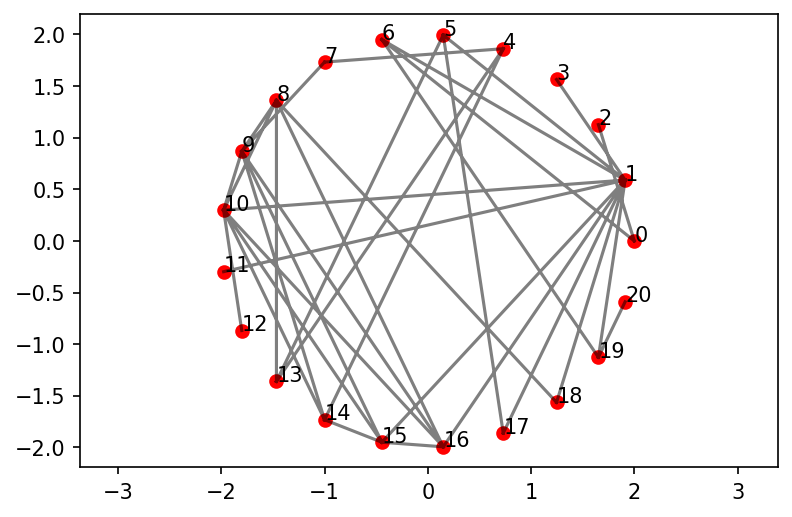

In [34]:
graph = Graph()
N = 20
#M = 13 
#graph.init_random(N,M)
gamma = 1.5
graph.init_powerlaw(N,gamma)
#graph.print()
fig,ax = plt.subplots()
graph.plot( graph.x, ax )
#anim = graph.animate()
#anim

### Rendering

In [ ]:
def render(tree_depth=5, angle = np.pi/6, switch_sym=0, colormap='winter'):
    # build the tree
    squares, colors, points = build_tree(tree_depth, angle, bool(switch_sym))
    
    pc = PatchCollection(squares, cmap=plt.colormaps[colormap], alpha=0.7)
    pc.set_array(colors)
    
    fig,ax = plt.subplots(figsize=(8,8))
    ax.add_collection(pc)
    ax.plot([],[]) #empty plot
    #ax.plot([p[0] for  p in points], [p[1] for p in points],'r.')
    #ax.set_title(f"Pythagoras' Tree\n with angle $\\alpha_0$={angle}, N={N} iterations")
    ax.axis('equal')
    ax.axis('off')
    plt.tight_layout()
    #plt.savefig('tree.png')
    #plt.savefig('tree.eps')
    plt.show()

dict_args = {
    "tree_depth": widgets.IntSlider(min=1, max=16, step=1, value=10),
    "angle": widgets.FloatSlider(min=0.01, max=np.pi/2, step=.01, value=0.5),
    "switch_sym": widgets.IntSlider(min=0, max=1, value=1),
    "colormap": widgets.Dropdown(options=['winter','cool','coolwarm','RdYlGn','twilight_shifted','hsv','rainbow','gist_earth'], value='winter')
}

widgets.interact_manual(render, **dict_args);